In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import random
from scipy.stats import percentileofscore

In [2]:
df_original = pd.read_csv('TMDB_movies.csv')
df_movies = df_original.copy()
S1 = df_original.shape[0]

### **Data Cleaning**
- Locate and sum null values for each column
- Do the same for empty lists and zeros
- Concatenate and plot results

In [3]:
nulls = df_movies.isnull().sum()                                                                 # Sum nulls across columns
nulls = (nulls[nulls > 0].sort_values(ascending = False))*100/S1                                 # Extract nonz zero values and sort
Outliers = pd.DataFrame({'Vals': nulls, 'Group': ['null'] * nulls.shape[0]}).reset_index()       # Initialize new dataframe

empty = (df_original == '[]').sum()
empty = empty[empty > 0].sort_values(ascending = False)*100/S1
Outliers2 = pd.DataFrame({'Vals': empty, 'Group': ['[]'] * empty.shape[0]}).reset_index()

zero = (df_original == 0).sum()
zero = zero[zero > 0].sort_values(ascending = False)*100/S1
Outliers3 = pd.DataFrame({'Vals': zero, 'Group': ['0'] * zero.shape[0]}).reset_index()

All_outliers = pd.concat([Outliers, Outliers2, Outliers3])                    # Combine dataframes
All_outliers.iloc[14,0] = 'runtime_2'
    


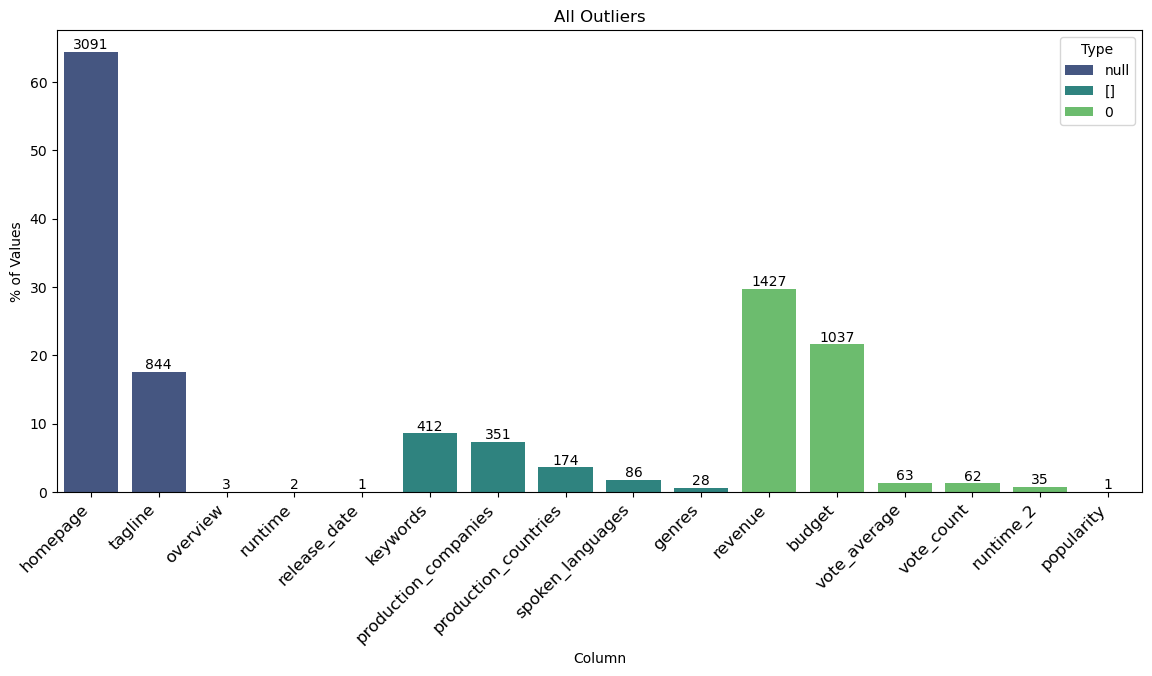

In [4]:
plt.figure(figsize=(14, 6))
sns.barplot(x='index', y='Vals', hue='Group',data=All_outliers, palette='viridis', width=0.8, dodge = False)

for i, value in enumerate(All_outliers['Vals']):
    plt.text(i, value, str(round((value*S1)/100)), ha='center', va='bottom')     # Writes number on graph for clarity
    
plt.legend(title='Type')
plt.xticks(rotation=45, 
           horizontalalignment = 'right', 
           fontweight = 'light',
           fontsize = 'large') # setting the fonts
plt.title('All Outliers')
plt.xlabel('Column')
plt.ylabel('% of Values')
          
plt.show()

- Some key values missig such as runtime and release_date, only a few however
- Some extra information such as keywords are missing, making the data harder to classify
- No missing values for revenue and budget, however many values are zero



### **Budget and Revenue Investigations**
- Comparisons between database and IMDB values
- Missing values are seen to be stored as 0
- Some particular values are recorded in millions of dollars opposed to dollars
    * Only a small portion oif the data, should be mostly rectifiable
- Some more values such as for Nurse 3-D have chaotic behaviour
- Some values may be in their original currency, however there is not enough information to say for certain
    * Seems that most films with different currencies on IMDB are missing these values in the dataset

In [5]:
df_outlier = df_original.iloc[[2669,3419,3137]][['original_title','budget','revenue']].copy()
df_outlier['budget_IMDB'] = ['$14,000,000','A$6500000','$10,000,000']
df_outlier['revenue_IMDB'] = ['$239,606,210','$6816269','$706,617']
df_outlier

# Values taken from the IMDB website

,original_title,budget,revenue,budget_IMDB,revenue_IMDB
2669,Crocodile Dundee II,0,239606210,"$14,000,000","$239,606,210"
3419,Bran Nue Dae,7,7,A$6500000,$6816269
3137,Nurse 3-D,10,10000000,"$10,000,000","$706,617"


In [6]:
film_oi2 = df_original.iloc[3419]
percentile1 = percentileofscore(df_original['popularity'], film_oi2['popularity'])

### **Bran Nue Dae Investigations**
* Bottom 2% of popularity
* Missing values in homepage, production companies, production countries and spoken languages
    * Instances of outliers may be correlated

### **Correlation Checks**
* Create 4 new columns of boolean values answering the following questions
    * Was the film produced Internationally?
    * Is the original language Foreign?
    * Is the budget missing?
    * Is the revenue missing?

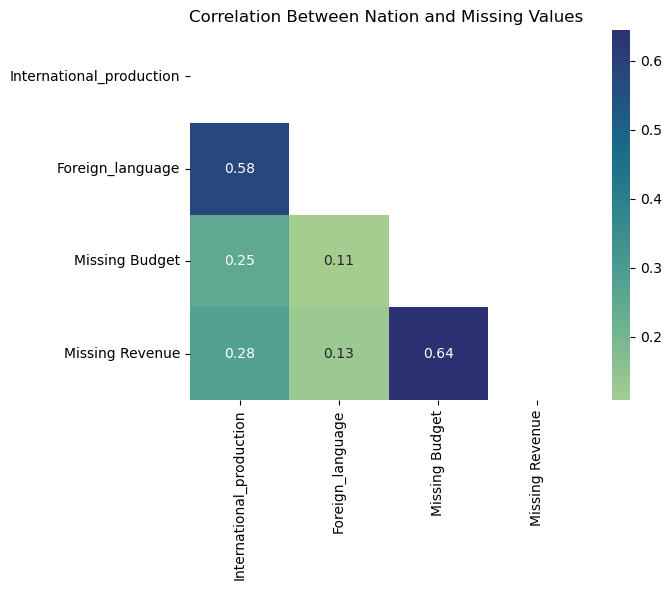

In [7]:
def International_prod(txt):
    if re.search('.*"United Kingdom".*', txt):
        return 0
    elif re.search('.*"United States of America".*', txt):
        return 0
    else:
        return 1
    
df_movies['International_production'] = df_movies['production_countries'].apply(International_prod)

def Foreign_lang(txt):
    if txt == 'en':
        return 0
    else:
        return 1
    
df_movies['Foreign_language'] = df_movies['original_language'].apply(Foreign_lang)

def Check_if_0(val):
    if val == 0:
        return 1
    else:
        return 0
    
df_movies['Missing Budget'] = df_movies['budget'].apply(Check_if_0)
df_movies['Missing Revenue'] = df_movies['revenue'].apply(Check_if_0)
corr_matrix = df_movies[['International_production','Foreign_language','Missing Budget','Missing Revenue']].corr()

mask = np.triu(np.ones_like(corr_matrix))
sns.heatmap(corr_matrix,mask = mask,annot=True, cmap = 'crest')
plt.title('Correlation Between Nation and Missing Values ')
plt.show()

* Very high correlation between missing budget and missing Revenue
* If a film is missing it's budget, ther is a higher chance it is missing revenue
* Missing values are not at random, there is a pattern
* Also correlation between 'International_Production and missing values
    * International films are more likely to miss values

### **Genre and keywords counts**
* Each film is tagged by between 0 and 7 genres
* Number of keywords are more varied
    * 1 outlier with almost 100 keywords

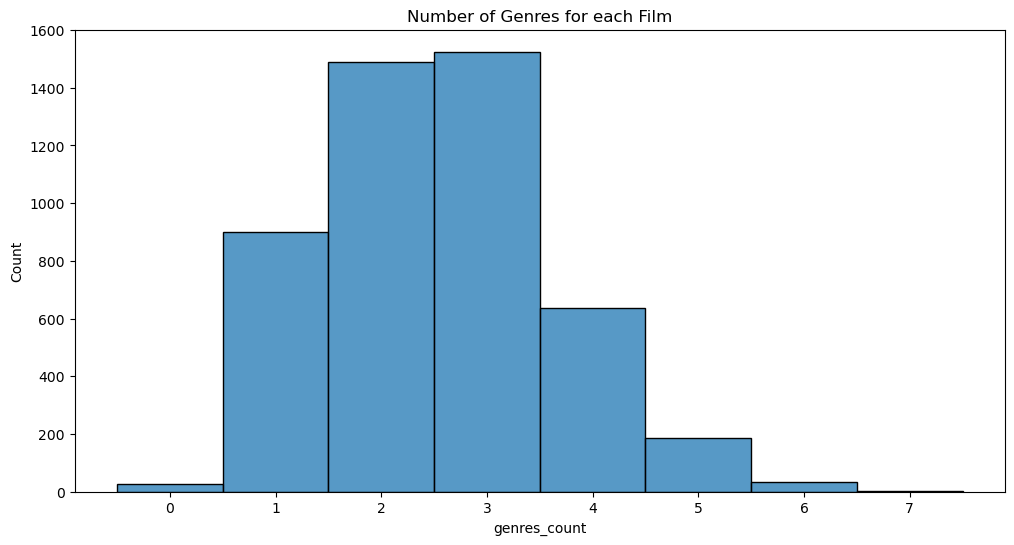

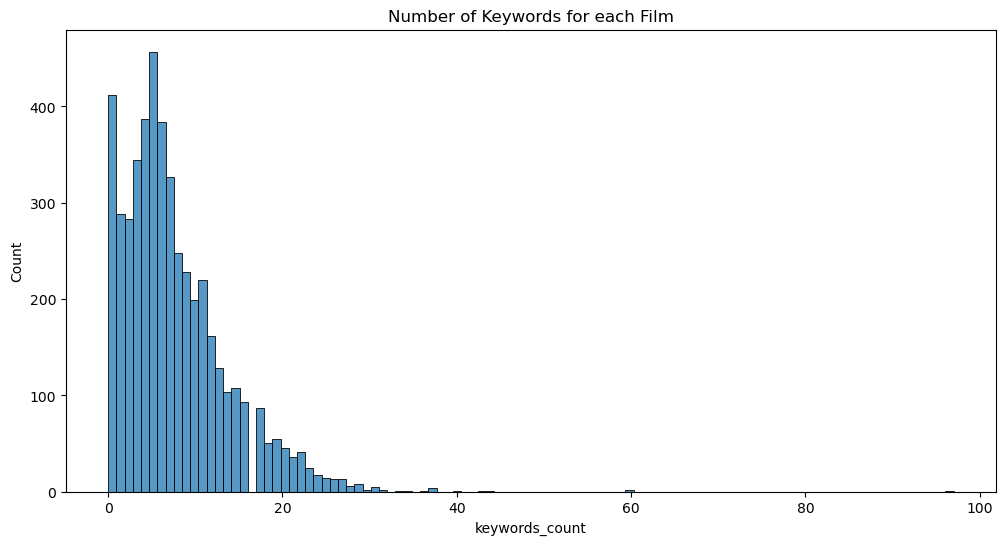

In [8]:
df_movies

def count_instances(x):
    vals = json.loads(x)
    return len(vals)
    
df_movies['genres_count'] = df_movies['genres'].apply(count_instances)
df_movies['keywords_count'] = df_movies['keywords'].apply(count_instances)

plt.figure(figsize=(12,6))
sns.histplot(df_movies['genres_count'], discrete=True)
plt.title('Number of Genres for each Film')
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(df_movies['keywords_count'])

plt.title('Number of Keywords for each Film')
plt.show()

In [9]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', None)
film_oi = df_movies[df_movies['keywords_count'] > 80]
film_oi[['keywords']]

,keywords
2428,"[{""id"": 255, ""name"": ""male nudity""}, {""id"": 293, ""name"": ""female nudity""}, {""id"": 331, ""name"": ""tattoo""}, {""id"": 395, ""name"": ""gambling""}, {""id"": 417, ""name"": ""corruption""}, {""id"": 494, ""name"": ""father son relationship""}, {""id"": 549, ""name"": ""prostitute""}, {""id"": 642, ""name"": ""robbery""}, {""id"": 703, ""name"": ""detective""}, {""id"": 796, ""name"": ""police brutality""}, {""id"": 1157, ""name"": ""wife husband relationship""}, {""id"": 1317, ""name"": ""card game""}, {""id"": 1333, ""name"": ""desperation""}, {""id"": 1568, ""name"": ""undercover""}, {""id"": 1930, ""name"": ""kidnapping""}, {""id"": 2231, ""name"": ""drug dealer""}, {""id"": 4948, ""name"": ""retirement""}, {""id"": 4959, ""name"": ""death of a friend""}, {""id"": 5504, ""name"": ""asthma""}, {""id"": 6149, ""name"": ""police""}, {""id"": 7410, ""name"": ""fellatio""}, {""id"": 8636, ""name"": ""blood splatter""}, {""id"": 9748, ""name"": ""revenge""}, {""id"": 9758, ""name"": ""deception""}, {""id"": 9826, ""name"": ""murder""}, {""id"": 10085, ""name"": ""betrayal""}, {""id"": 10093, ""name"": ""priest""}, {""id"": 10688, ""name"": ""breast""}, {""id"": 10856, ""name"": ""bag of money""}, {""id"": 10950, ""name"": ""shootout""}, {""id"": 10954, ""name"": ""blood on shirt""}, {""id"": 11113, ""name"": ""shot in the back""}, {""id"": 11199, ""name"": ""undercover cop""}, {""id"": 11221, ""name"": ""blood""}, {""id"": 11258, ""name"": ""suicidal""}, {""id"": 11314, ""name"": ""f word""}, {""id"": 11325, ""name"": ""shot to death""}, {""id"": 11430, ""name"": ""punched in the face""}, {""id"": 11436, ""name"": ""redemption""}, {""id"": 11522, ""name"": ""police officer killed""}, {""id"": 11612, ""name"": ""hospital""}, {""id"": 11719, ""name"": ""dirty cop""}, {""id"": 11734, ""name"": ""police corruption""}, {""id"": 13132, ""name"": ""pistol""}, {""id"": 14512, ""name"": ""new york city""}, {""id"": 14765, ""name"": ""church""}, {""id"": 14819, ""name"": ""violence""}, {""id"": 14829, ""name"": ""strangulation""}, {""id"": 14967, ""name"": ""foot chase""}, {""id"": 15167, ""name"": ""police detective""}, {""id"": 15300, ""name"": ""father daughter relationship""}, {""id"": 15321, ""name"": ""police station""}, {""id"": 18320, ""name"": ""held at gunpoint""}, {""id"": 18396, ""name"": ""catholic""}, {""id"": 33720, ""name"": ""guilt""}, {""id"": 41523, ""name"": ""brooklyn new york city""}, {""id"": 155799, ""name"": ""narcotics cop""}, {""id"": 156022, ""name"": ""nypd""}, {""id"": 156091, ""name"": ""missing person""}, {""id"": 156158, ""name"": ""racial slur""}, {""id"": 156788, ""name"": ""swat team""}, {""id"": 159753, ""name"": ""ensemble cast""}, {""id"": 161534, ""name"": ""pregnant wife""}, {""id"": 166477, ""name"": ""confessional""}, {""id"": 166492, ""name"": ""drive by shooting""}, {""id"": 167536, ""name"": ""shot in the shoulder""}, {""id"": 168869, ""name"": ""gun in mouth""}, {""id"": 169590, ""name"": ""police raid""}, {""id"": 172792, ""name"": ""reference to god""}, {""id"": 175233, ""name"": ""razor blade""}, {""id"": 175241, ""name"": ""shot through a door""}, {""id"": 177554, ""name"": ""stealing money""}, {""id"": 180183, ""name"": ""police officer shot""}, {""id"": 180702, ""name"": ""expecting twins""}, {""id"": 185795, ""name"": ""lens flare""}, {""id"": 187844, ""name"": ""flashback""}, {""id"": 188259, ""name"": ""money problems""}, {""id"": 194780, ""name"": ""family man""}, {""id"": 207268, ""name"": ""neo-noir""}, {""id"": 210245, ""name"": ""bmw""}, {""id"": 210541, ""name"": ""apathy""}, {""id"": 217989, ""name"": ""confession booth""}, {""id"": 217992, ""name"": ""thoughts of retirement""}, {""id"": 217993, ""name"": ""hail mary""}, {""id"": 217996, ""name"": ""working in the nude""}, {""id"": 217997, ""name"": ""drug raid""}, {""id"": 217998, ""name"": ""ironing money""}, {""id"": 217999, ""name"": ""bedtime prayer""}, {""id"": 218000, ""name"": ""briefing""}

In [10]:
percentile = percentileofscore(df_movies['revenue'], film_oi['revenue'])
percentile1 = percentileofscore(df_movies['popularity'], film_oi['popularity'])

* Other than the markdowns the data is as expected
    * Not missing values
    * Top 45% for revenue
    * Tope 38% for popularity
    * 3 different genres

### **Simple data cleaning**
* Remove rows of important nulls such as 'runtime' and 'release_date'
* Remove rows where budget or revenue is equal to 0
    * This should be improved upon due to the high quantity of these missing values
    

In [11]:
df_clean = df_original.copy()

def clean(data):                        # Function to remove nulls
    data.dropna(
        axis = 0, # default
        how = 'any', # default
        subset = ['runtime', 'release_date'],  
        inplace = True)

    data = data[data['budget'] != 0]
    data = data[data['revenue'] != 0]
    data = data[data['runtime'] != 0]
    data = data[data['vote_average'] != 0]
    data = data[data['popularity'] != 0]
    
    return data

df_clean = clean(df_clean)

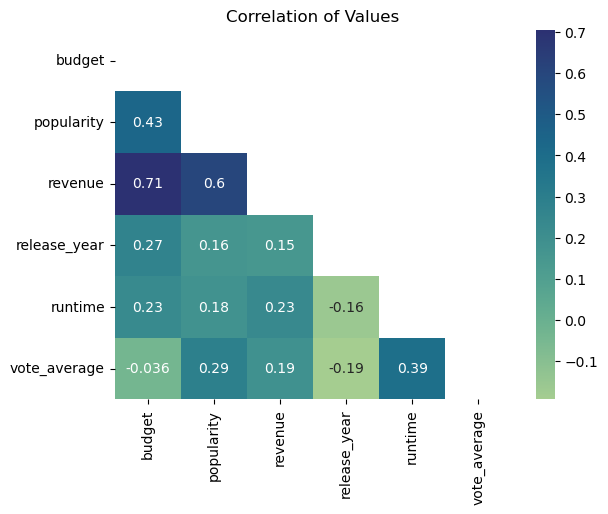

In [12]:
df_numeric = df_clean[['budget','popularity','revenue','release_date','runtime','vote_average']].copy()
df_numeric['release_date'] = df_numeric['release_date'].str.split('-', expand=True)[0].astype(float)         # Extract and replace deate with year
df_numeric.rename(columns = {'release_date':'release_year'},inplace = True)            

val_corr = df_numeric.corr()

mask = np.triu(np.ones_like(val_corr))
sns.heatmap(val_corr,mask = mask,cmap = 'crest',annot = True)
plt.title('Correlation of Values')
plt.show()



### **Correlation Analysis**
* Revenue budget and popularity are highly correlated as expected
* Films get more expensive and more popular as time goes on, however their runtime and rating decreases. 
* Interestingly budget has not correlation with the average vote, however, runtime has considerable correlation with this
    * People like longer films

### **Genre Investigations**
* We can find mean values of different columns for each genre

In [13]:
df_genres = df_original.copy()

unique_genre = set()
lst = df_genres['genres']
for i in lst:                               # Find all unique genres
    x = json.loads(i)
    for i in range(len(x)):
        unique_genre.add(x[i]['name'])

unique_genre = list(unique_genre)

In [14]:
def grouping(txt,genre):                              
    if re.search('.*"' + genre + '".*', txt):
        return 1
    else:
        return 0

for genre in unique_genre:                                                  # Creates new 'boolean' columns for each genre
    df_genres[genre] = df_genres['genres'].apply(grouping, genre=genre)


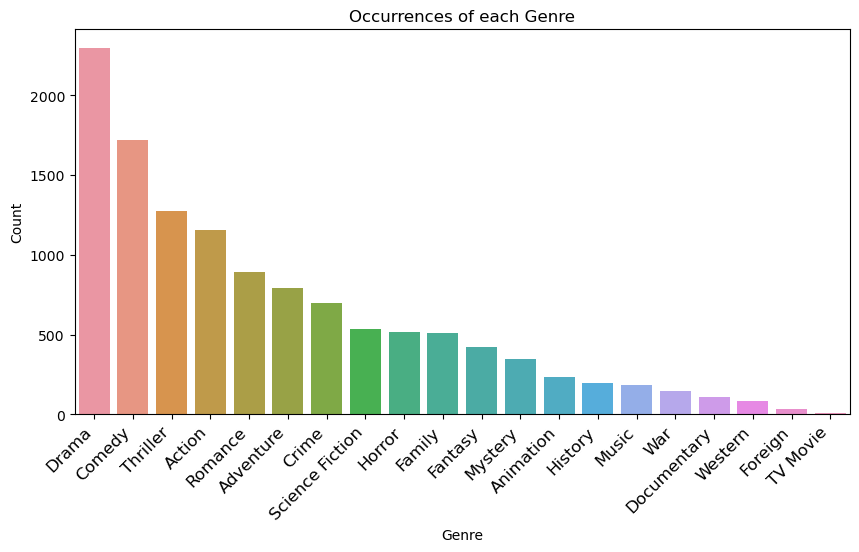

In [15]:
# Analysis for the global count of each genre

genre_booleans = df_genres.iloc[:,20:].copy()

genre_counts = genre_booleans.sum().reset_index()
genre_counts.columns = ['Genre', 'Count']
genre_counts.sort_values(by='Count', ascending=False,inplace = True)
plt.figure(figsize = (10,5))
sns.barplot(x = 'Genre', y = 'Count',data = genre_counts)
plt.xticks(rotation=45, # rotating labels
           horizontalalignment = 'right', # aligning them with the bars
           fontweight = 'light',
           fontsize = 'large' # setting the fonts
          )

plt.title('Occurrences of each Genre') # naming the plot

plt.show()


* Drama and Comedy are suprisingly the top 2 by far
    * They are likely common secondary genres

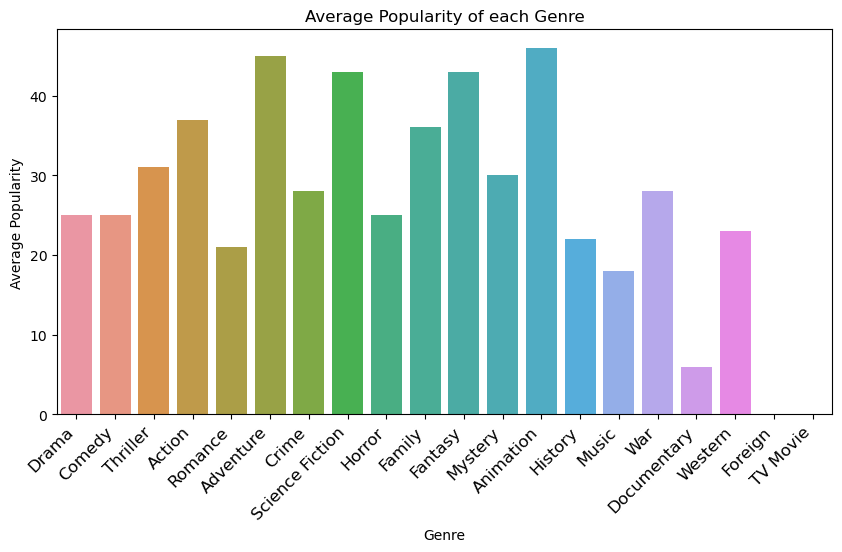

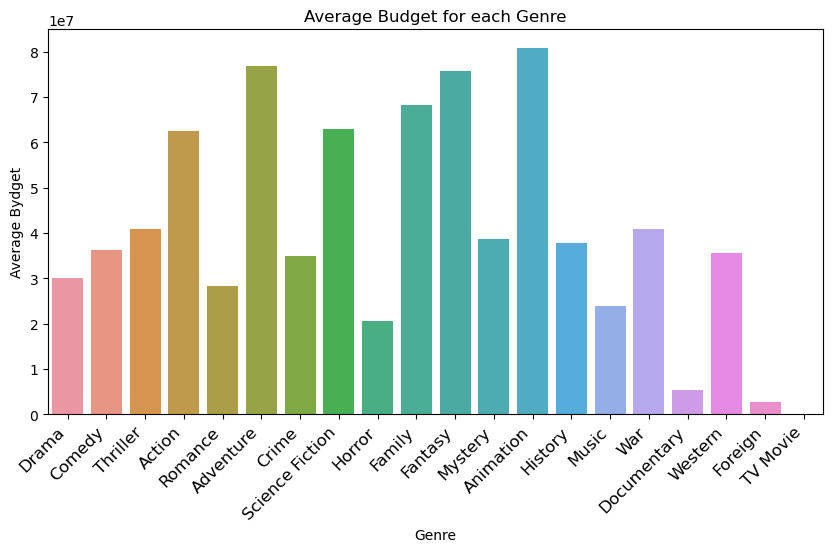

In [16]:
# Analysis for Popularity

df_clean_genres = clean(df_genres.copy())     # Make sure this dataset is cleaned
avgs = [df_clean_genres[df_clean_genres[genre] == 1]['popularity'].mean() for genre in unique_genre]

shuffle_index = genre_counts.reset_index().copy()['index']
avgs = np.array(avgs)[list(shuffle_index)].round()

plt.figure(figsize = (10,5))
sns.barplot(x = 'Genre', y = avgs,data = genre_counts)
plt.xticks(rotation=45, # rotating labels
           horizontalalignment = 'right', # aligning them with the bars
           fontweight = 'light',
           fontsize = 'large')
plt.title('Average Popularity of each Genre')
plt.ylabel('Average Popularity')
plt.show()

# Same for Budget

avgs = [df_clean_genres[df_clean_genres[genre] == 1]['budget'].mean() for genre in unique_genre]

avgs = np.array(avgs)[list(shuffle_index)].round()

plt.figure(figsize = (10,5))
sns.barplot(x = 'Genre', y = avgs,data = genre_counts)
plt.xticks(rotation=45, # rotating labels
           horizontalalignment = 'right', # aligning them with the bars
           fontweight = 'light',
           fontsize = 'large')
plt.title('Average Budget for each Genre')
plt.ylabel('Average Bydget')
plt.show()


* The most popular genres are Action, Adventure, Sci-fi, Fantasy, Animation
* These are also the most costly film to produce, explaining why they aren't the most common genres

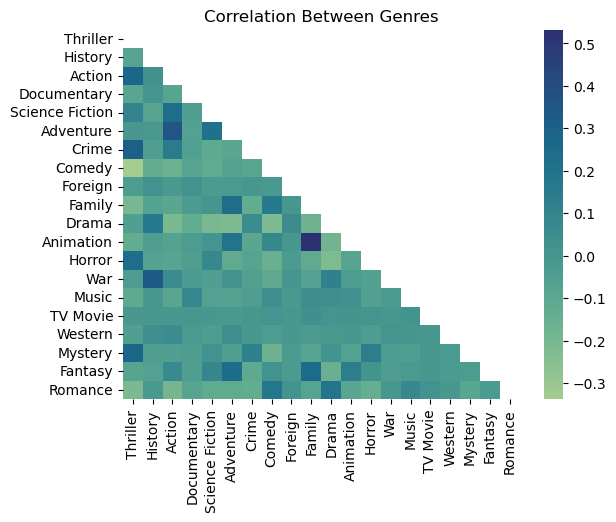

In [17]:
mask = np.triu(np.ones_like(genre_booleans.corr()))
sns.heatmap(genre_booleans.corr(method = 'pearson'),mask = mask,cmap = 'crest')
plt.title('Correlation Between Genres')
plt.show()

* Can plot the correlations between different genres
    * Which genres are likely to appear together?
* Thriller is the most discriminative, high and low correlations
* Highest correlation between animation and family
* These values could help inform a movie recommender system